In [2]:
from src.conv_seq2seq import *
from src.utils import *
from src.layers import MaskedCrossEntropyLoss
import torch 
import torch.optim as optim
import random

# Setup

In [3]:
# OPTIONS: 
# ENGLISH - en, 
# GERMAN - de, 
# FRENCH - fr, 
# CZECH - cs

lang1 = 'de'
lang2 = 'en'

train_sentences, test_sentences = load_data(lang1, lang2)
train_sentences = (train_sentences[0][:500], train_sentences[1][:500])

In [4]:
TEST_SIZE=0.2
BATCH_SIZE=64
VALID_BATCH_SIZE=128
MAX_VOCAB=20000

src_vocab, tgt_vocab, train_loader, valid_loader = make_dataset(train_sentences, test_sentences, BATCH_SIZE, VALID_BATCH_SIZE, MAX_VOCAB)

In [5]:
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(valid_loader.dataset)}")
print(f"Training Batches {len(train_loader)}\tValidation Batches {len(valid_loader)}")

Number of training examples: 500
Number of validation examples: 1014
Training Batches 8	Validation Batches 8


In [6]:
print(f"Unique tokens in source ({lang1}) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target ({lang2}) vocabulary: {len(tgt_vocab)}")

Unique tokens in source (de) vocabulary: 1348
Unique tokens in target (en) vocabulary: 1224


# Make the Model

In [29]:
# ENCODER ARGS
ENC_UNITS = 128 # 512
ENC_EMBEDDING = 256 # 256
SRC_VOCAB_SIZE = len(src_vocab)
ENC_NUM_LAYERS = 3 # 10
ENC_KERNEL_SIZE = 3 # ODD
DROPOUT = 0.25

# DECODER ARGS
DEC_UNITS = ENC_UNITS
DEC_EMBEDDING = ENC_EMBEDDING
TGT_VOCAB_SIZE = len(tgt_vocab)
DEC_NUM_LAYERS = ENC_NUM_LAYERS
DEC_KERNEL_SIZE = 3 # EVEN OR ODD
PAD_IDX = tgt_vocab.PAD_token


# SEQ2SEQ ARGS
MAX_LENGTH = max(train_loader.dataset.tensors[1].size(1), train_loader.dataset.tensors[0].size(1)) + 3
SOS_TOKEN = tgt_vocab.SOS_token
TEACHER_FORCING = 1.0

In [30]:
encoder = Encoder(SRC_VOCAB_SIZE, ENC_EMBEDDING, ENC_UNITS, ENC_NUM_LAYERS, ENC_KERNEL_SIZE, DROPOUT, MAX_LENGTH)
decoder = Decoder(DEC_UNITS, DEC_EMBEDDING, TGT_VOCAB_SIZE, DEC_NUM_LAYERS, DEC_KERNEL_SIZE, DROPOUT, PAD_IDX, MAX_LENGTH)

seq2seq = Seq2Seq(encoder, decoder, TEACHER_FORCING, MAX_LENGTH, SOS_TOKEN)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 1,787,208 trainable parameters


In [31]:
print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (token_embedding): Embedding(1348, 256)
    (position_embedding): Embedding(49, 256)
    (embed2hidden): Linear(in_features=256, out_features=128, bias=True)
    (hidden2embed): Linear(in_features=128, out_features=256, bias=True)
    (convs): Sequential(
      (0): EncoderConv(
        (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (1): EncoderConv(
        (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (2): EncoderConv(
        (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (token_embedding): Embedding(1224, 256)
    (position_embedding): Embedding(49, 256)
    (embedd2hidden): Linear(in_features=256, out_features=128,

In [32]:
criterion = MaskedCrossEntropyLoss(pad_tok=tgt_vocab.PAD_token)
optimizer = optim.Adam(seq2seq.parameters())

# Train

In [33]:
# valid_loss = evaluate(seq2seq, valid_loader, criterion)

In [34]:
# valid_loss

In [35]:
idx = 55
src_sentence = train_loader.dataset.tensors[0][idx:idx+1][:, :20]
tgt_sentence = train_loader.dataset.tensors[1][idx:idx+1][:, :20]
print(src_sentence[:, :19])
print(tgt_sentence[:, :21])
print(src_sentence.size(), tgt_sentence.size())
print(src_vocab.to_string(src_sentence))
print(tgt_vocab.to_string(tgt_sentence))

tensor([[  2,   5,  12,   8,   7, 177,  70,  26,  19, 117, 579, 148,   6,  16,
         300,  18, 177, 151,   3]])
tensor([[  3,   2,   9,   6,   2, 139,  10,  77, 345,  16, 135, 592,  14, 317,
          81,   6,   2, 139,   5,   4]])
torch.Size([1, 20]) torch.Size([1, 20])
['<sos> ein mann in einem anzug rennt an zwei anderen herren vorbei , die auch einen anzug tragen . <eos>']
['<sos> a man in a suit is running past two other gentleman , also dressed in a suit . <eos>']


In [36]:
out, attention = seq2seq(src_sentence)

In [37]:
out.size(), attention.size()

(torch.Size([1, 49, 1224]), torch.Size([1, 49, 20]))

In [38]:
translation = tgt_vocab.to_string(out.argmax(dim=-1))[0]
translation

'fruits pilot slowly main men uniformly trying talkie books atop woman gap decorations helmet seven atv sitting sculpture sparks dressed shovels tells kicking device men house walkman lays burgers medium-sized bowl steel cutting day wet burgers duck scene mom holding hikers sky washes blond-hair steel approaching girl cow tree'

In [ ]:
N_EPOCHS = 50
CLIP = 1

seq2seq.teacher_forcing = 0.

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    
    train_loss = train(seq2seq, train_loader, optimizer, criterion, CLIP, src_vocab.PAD_token)
    valid_loss = evaluate(seq2seq, train_loader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'models/seq2seq_conv.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:15<01:45, 15.08s/it]

 25%|██▌       | 2/8 [00:28<01:26, 14.48s/it]

 38%|███▊      | 3/8 [00:44<01:14, 14.92s/it]

 50%|█████     | 4/8 [00:57<00:57, 14.37s/it]

 62%|██████▎   | 5/8 [01:10<00:41, 13.95s/it]

 75%|███████▌  | 6/8 [01:23<00:27, 13.62s/it]

 88%|████████▊ | 7/8 [01:36<00:13, 13.49s/it]

100%|██████████| 8/8 [01:47<00:00, 12.90s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:30,  4.33s/it]

 25%|██▌       | 2/8 [00:07<00:24,  4.01s/it]

 38%|███▊      | 3/8 [00:10<00:19,  3.81s/it]

 50%|█████     | 4/8 [00:14<00:15,  3.79s/it]

 62%|██████▎   | 5/8 [00:18<00:11,  3.67s/it]

 75%|███████▌  | 6/8 [00:21<00:07,  3.72s/it]

 88%|████████▊ | 7/8 [00:25<00:03,  3.70s/it]

100%|██████████| 8/8 [00:28<00:00,  3.36s/it]	Train Loss: 2.948 | Train PPL:  19.065
	 Val. Loss: 2.471 |  Val. PPL:  11.833
Epoch: 02


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:15<0

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:12<01:26, 12.30s/it]

 25%|██▌       | 2/8 [00:24<01:13, 12.27s/it]

 38%|███▊      | 3/8 [00:36<01:01, 12.27s/it]

 50%|█████     | 4/8 [00:49<00:49, 12.44s/it]

 62%|██████▎   | 5/8 [01:02<00:37, 12.56s/it]

 75%|███████▌  | 6/8 [01:14<00:25, 12.54s/it]

 88%|████████▊ | 7/8 [01:27<00:12, 12.50s/it]

100%|██████████| 8/8 [01:37<00:00, 11.70s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:21,  3.10s/it]

 25%|██▌       | 2/8 [00:06<00:18,  3.10s/it]

 38%|███▊      | 3/8 [00:09<00:15,  3.12s/it]

 50%|█████     | 4/8 [00:12<00:12,  3.11s/it]

 62%|██████▎   | 5/8 [00:15<00:09,  3.12s/it]

 75%|███████▌  | 6/8 [00:18<00:06,  3.12s/it]

 88%|████████▊ | 7/8 [00:21<00:03,  3.12s/it]

100%|██████████| 8/8 [00:24<00:00,  2.93s/it]	Train Loss: 2.775 | Train PPL:  16.042
	 Val. Loss: 2.274 |  Val. PPL:   9.718
Epoch: 10


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:11<01:22, 11.80s

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:12<01:28, 12.62s/it]

 25%|██▌       | 2/8 [00:27<01:20, 13.35s/it]

 38%|███▊      | 3/8 [00:39<01:05, 13.02s/it]

 50%|█████     | 4/8 [00:53<00:53, 13.26s/it]

 62%|██████▎   | 5/8 [01:09<00:42, 14.16s/it]

 75%|███████▌  | 6/8 [01:26<00:29, 14.82s/it]

 88%|████████▊ | 7/8 [01:39<00:14, 14.32s/it]

100%|██████████| 8/8 [01:49<00:00, 13.17s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:21,  3.06s/it]

 25%|██▌       | 2/8 [00:06<00:18,  3.06s/it]

 38%|███▊      | 3/8 [00:09<00:15,  3.05s/it]

 50%|█████     | 4/8 [00:12<00:12,  3.06s/it]

 62%|██████▎   | 5/8 [00:15<00:09,  3.04s/it]

 75%|███████▌  | 6/8 [00:18<00:06,  3.04s/it]

 88%|████████▊ | 7/8 [00:21<00:03,  3.04s/it]

100%|██████████| 8/8 [00:23<00:00,  2.87s/it]	Train Loss: 2.630 | Train PPL:  13.867
	 Val. Loss: 2.079 |  Val. PPL:   7.999
Epoch: 18


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:12<01:25, 12.22s

In [47]:
def evaluate_translate(model, iterator, criterion, pad_tok=0):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, tgt) in enumerate(tqdm(iterator, file=sys.stdout)):
            # src.shape = (batch_size, src_seq_len)
            # tgt.shape = (batch_size, tgt_seq_len)
            src_mask = create_padding_mask(src, pad_tok)

            if model.type == 'rnn':
                output, attention = model(src, None, src_mask) #turn off teacher forcing
                # output.shape == (batch_size, max_length, tgt_vocab_size)
                # print(output)
                # output = output[:, 1:, :]
                tgt = tgt[:, 1:]
            elif model.type == 'conv':
                output, attention = model(src, None) #turn off teacher forcing
                tgt = tgt[:, 1:]

            loss = criterion(output, tgt) # masked loss automatically slices for you

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [48]:
valid_loss = evaluate_translate(seq2seq, train_loader, criterion)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:26,  3.84s/it]

 25%|██▌       | 2/8 [00:07<00:23,  3.84s/it]

 38%|███▊      | 3/8 [00:12<00:20,  4.05s/it]

 50%|█████     | 4/8 [00:16<00:16,  4.13s/it]

 62%|██████▎   | 5/8 [00:20<00:12,  4.20s/it]

 75%|███████▌  | 6/8 [00:25<00:08,  4.30s/it]

 88%|████████▊ | 7/8 [00:30<00:04,  4.41s/it]

100%|██████████| 8/8 [00:33<00:00,  4.13s/it]

In [49]:
valid_loss

4.000765800476074

In [77]:
idx = 99

src_sentence = train_loader.dataset.tensors[0][idx:idx+1]
tgt_sentence = train_loader.dataset.tensors[1][idx:idx+1]

src_sentence = src_vocab.to_string(src_sentence, remove_special=True)[0]
tgt_sentence = tgt_vocab.to_string(tgt_sentence, remove_special=True)[0]

In [78]:
translation, attention = translate(src_sentence, seq2seq, src_vocab, tgt_vocab, src_vocab.PAD_token)

tensor([[  2,  15,  12,  13,  24, 671,  31,  17, 672,  51, 347,  37,  14, 673,
          11, 162,   3,   4]])
tensor([[   7,    9,   20,  186,  335,  162,  455,  686,  186,  192,  168,  824,
           35,   69, 1132,   11,   29,   35,   54,  141,  237,   82,   14,   20,
            2,   60,   41,  838,   69,  825,  849,   88,  141,    7,  141,  141,
          186,  284,   13,   37,  186,   20,  186,  186,   20,  123,  186,   20,
          141]])


In [79]:
print(f"> {src_sentence}")
print(f"= {tgt_sentence}")
print(f"< {translation}")

> der mann mit dem rucksack sitzt im hof eines gebaudes vor einer skulptur und liest .
= the man with the backpack is sitting in a buildings courtyard in front of an art sculpture reading .
< the man wearing hard balloon vest bathing phone hard outdoors about stoop men one secures and girl men child face something background , wearing a yellow her canister one she he grass face the face face hard shirtless with green hard wearing hard hard wearing orange hard wearing face


In [80]:
src_vocab.PAD_token

0

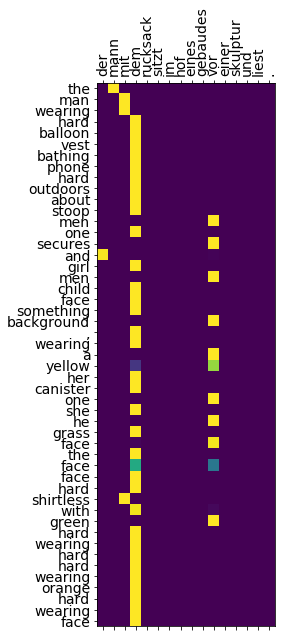

In [81]:
plot_attention(attention, src_sentence, translation)

In [55]:
attention

tensor([[4.3664e-11, 1.0312e-04, 1.2130e-21, 3.2909e-11, 1.0098e-01, 4.4736e-09,
         1.2194e-10, 8.9715e-10, 2.9493e-08, 2.2802e-06, 3.1995e-07, 1.0730e-09,
         5.1280e-10, 8.9890e-01, 1.6924e-05],
        [1.2821e-07, 2.2048e-11, 2.5935e-09, 8.2775e-04, 9.6637e-01, 1.8144e-03,
         3.6247e-08, 2.3610e-04, 2.4396e-05, 4.4837e-04, 2.9789e-02, 6.7302e-11,
         3.1570e-04, 1.6431e-04, 1.5167e-10],
        [9.7672e-09, 6.2471e-34, 8.9530e-07, 1.5813e-14, 3.4575e-20, 6.9667e-19,
         5.8963e-15, 1.4152e-18, 6.0852e-06, 5.0482e-12, 5.8400e-28, 2.9403e-39,
         4.2869e-13, 4.5173e-11, 9.9999e-01],
        [3.0974e-24, 6.0256e-44, 0.0000e+00, 3.3918e-30, 1.8024e-25, 8.6161e-30,
         1.4547e-22, 8.9977e-25, 8.0511e-24, 3.4063e-20, 2.0275e-40, 0.0000e+00,
         2.0891e-32, 7.1727e-18, 1.0000e+00],
        [8.9777e-29, 0.0000e+00, 0.0000e+00, 1.0618e-32, 7.0668e-37, 3.0974e-39,
         2.0014e-30, 1.1380e-33, 3.5251e-30, 6.0993e-26, 0.0000e+00, 0.0000e+00,
      

In [ ]:
# valid_loss = evaluate(seq2seq, valid_loader, criterion)